In [1]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from clones.data.experiments import Experiment

from clones.annotation.bayesian import BayesianClassifier
from clones.annotation.model_selection import ModelSelection
from clones.annotation.community import KatzLabeler, InfomapLabeler

from clones.visualization.settings import *
figsize = (2, 2)
savedir = './graphics/example_disc/'
savefig = lambda fig, name: fig.savefig(join(savedir, '{:s}.pdf'.format(name)), dpi=400, rasterized=True, transparent=True)

# Load microscopy data

Confocal images are of a bleedthrough control experiment consisting of three color channels:
   - BLUE: Nuclear stain
   - RED: Clonal marker
   - GREEN: Control reporter (expressed equally within a vertical stripe of cells near the furrow)
   
We will use the first layer of the 4th stack as an example.

In [3]:
stack_id = 4
layer_id = 0

In [4]:
# load experiment
experiment = Experiment('../../../data/drosophila/')

# load image stack
stack = experiment.load_stack(experiment.stack_ids[stack_id], full=True)
layer = stack[layer_id]

# aggregate measurement data
measurements = stack.aggregate_measurements(raw=False)

# filter cells marked for exclusion
#measurements = measurements[measurements.selected]

# Segmentation

We previously segmented this layer and saved the resultant labels. Here we can visualize them.

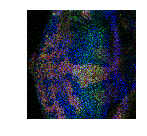

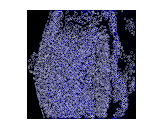

In [11]:
fig0 = layer.show(segments=False, figsize=figsize)
fig1 = layer.get_channel('b').show(segments=True, figsize=figsize, lw=.25, color='w', cmap='b')
savefig(fig0, 'microscopy')
savefig(fig1, 'segmentation')

# Fit mixture model

In [14]:
rfp_levels = measurements.r

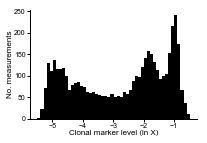

In [15]:
fig, ax = plt.subplots(figsize=(3, 2))
_ = ax.hist(np.log(rfp_levels), bins=50, color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('No. measurements')
ax.set_xlabel('Clonal marker level (ln X)')

savefig(fig, 'clonal_marker_histogram')

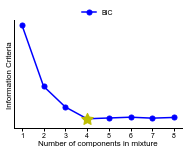

In [16]:
# model selection
selector = ModelSelection(rfp_levels, classify_on='r', min_num_components=1, max_num_components=8, crop=False)
fig = selector.plot_information_criteria(aic=False)
savefig(fig, 'model_selection')

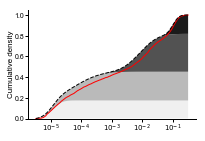

In [17]:
mixture_model = selector.BIC_optimal
fig = selector.BIC_optimal.plot_cdfs(log=True, cmap=plt.cm.Greys, alpha=1.)
from matplotlib.ticker import ScalarFormatter
ax = fig.axes[0]
_ = ax.set_xticklabels(['$10^{{{:d}}}$'.format(int(x)) for x in ax.get_xticks()])
savefig(fig, 'model_fit')

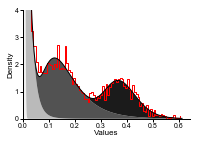

In [18]:
fig = mixture_model.stacked_pdfs(empirical=True, alpha=1.)
ax = fig.axes[0]
ax.set_ylim(0, 4)
savefig(fig, 'model_fit_pdf')

# Define mapping

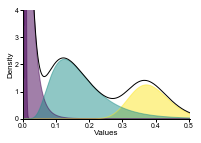

In [19]:
fig = mixture_model.plot_pdfs(empirical=False, alpha=0.5)
ax = fig.axes[0]
ax.set_ylim(0, 4)
savefig(fig, 'pdf_mapping')

# Simple classifier

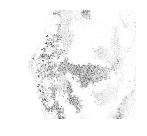

In [20]:
fig = layer.get_channel('r').show(segments=False, cmap=plt.cm.Greys, figsize=figsize)
savefig(fig, 'clonal_marker_image')

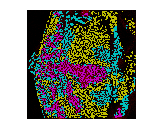

In [21]:
from matplotlib.colors import ListedColormap
label_mask = layer.build_mask(mixture_model)
fig = layer.get_channel('r').show(segments=False, cmap='r', figsize=figsize)
cmap = ListedColormap(['y', 'c', 'm', 'k'], N=4)
cmap.set_bad(alpha=0.)
fig.axes[0].imshow(label_mask, cmap=cmap, vmin=0, vmax=4, alpha=1.)
savefig(fig, 'simple_classification')

# Bleed-through control

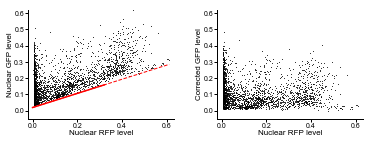

In [22]:
from clones.bleedthrough.correction import LayerCorrection, BackgroundExtraction
correction = LayerCorrection(layer, xvar='r', yvar='g', niters=50, resample=True)
correction.show_correction(selected_only=False)
fig = correction.figs['correction']
for ax in fig.axes:
    ax.set_title('')
savefig(fig, 'correction_applied')

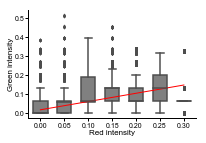

In [23]:
correction.show_fit(bin_size=0.05)
fig = correction.figs['fit']
savefig(fig, 'correction_fit')

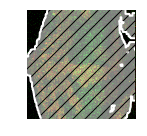

In [24]:
fig = correction.show_background_extraction(figsize=figsize)
savefig(fig, 'foreground_mask')

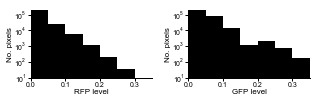

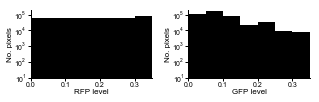

In [25]:
fig0, fig1 = correction.show_resampling()
savefig(fig0, 'bg_pixels_original')
savefig(fig1, 'bg_pixels_resampled')

# Annotation algorithm

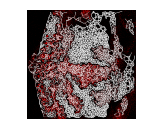

In [8]:
graph_kw = dict(node_size=0., node_alpha=0., lw=0.5, node_color='w', edge_alpha=1.,
                edge_color='w', colorby='community', disconnect=False)
image_kw = image_kw=dict(cmap='r')
fig = layer.plot_graph(figsize=figsize, graph_kw=graph_kw, image_kw=image_kw)
savefig(fig, 'graph')

# Community annotation

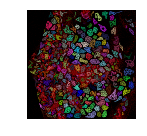

In [10]:
graph_kw = dict(node_size=0., node_alpha=0., lw=0.5, edge_alpha=1., colorby='community', disconnect=True)
image_kw = image_kw=dict(cmap='r')
fig = layer.plot_graph(figsize=figsize, graph_kw=graph_kw, image_kw=image_kw)
savefig(fig, 'communities')

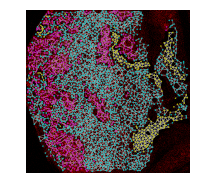

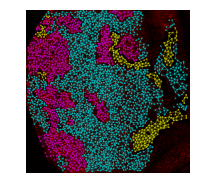

In [42]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['y', 'c', 'm'], 'indexed', 3)
fig7 = layer.plot_graph(figsize=figsize, node_size=.25, lw=1, colorby='km_label', node_cmap=cmap, disconnect=False, ec='w')

cmap = ListedColormap(['y', 'c', 'm'], 'indexed', 3)
fig8 = layer.plot_graph(figsize=figsize, node_size=.25, lw=1, colorby='genotype', node_cmap=cmap, disconnect=True)

fig7.savefig('../graphics/layer_annotation_raw.pdf', dpi=300, format='pdf', transparent=True, rasterized=True)
fig8.savefig('../graphics/layer_annotation_final.pdf', dpi=300, format='pdf', transparent=True, rasterized=True)